In [51]:
import numpy as np
import imageio
import cv2
import matplotlib.pyplot as plt

'''
original matlab code at https://www.robots.ox.ac.uk/~vgg/research/caltech/phog.html
'''

def anna_phog(Img, bin, angle, L, roi):
    '''
     anna_PHOG Computes Pyramid Histogram of Oriented Gradient over a ROI.
     [BH, BV] = anna_PHOG(Img,BIN,ANGLE,L,ROI) computes phog descriptor over a ROI.
     Given and image Img, phog computes the Pyramid Histogram of Oriented Gradients
     over L pyramid levels and over a Region Of Interest
    IN:
        Img- Images numpy array of size MxN (Color or Gray)
        bin - Number of bins on the histogram
        angle - 180 or 360
       L - number of pyramid levels
       roi - Region Of Interest (ytop,ybottom,xleft,xright)
    OUT:
        p - pyramid histogram of oriented gradients
    '''
    if Img.shape[2] == 3:
        G = cv2.cvtColor(Img, cv2.COLOR_BGR2GRAY)
    else:
        G = Img

    if np.sum(G) > 100:
        # apply automatic Canny edge detection using the computed median
        sigma = 0.33
        v = np.median(G)
        lower = int(max(0, (1.0 - sigma) * v))
        upper = int(min(255, (1.0 + sigma) * v))
        E = cv2.Canny(G,lower,upper) #high and low treshold
        GradientX, GradientY = np.gradient(G)
        GradientYY = np.gradient(GradientY, axis=1)

        Gr = np.sqrt(np.square(GradientX)+np.square(GradientY))
        index = GradientX == 0
        GradientX[index] = 1e-5 #maybe another value

        YX = GradientY*GradientX
        if angle == 180: A = ((np.arctan(YX)+(np.pi/2))*180)/np.pi
        if angle == 360: A = ((np.arctan2(GradientY,GradientX)+np.pi)*180)/np.pi

        bh, bv = anna_BinMatrix(A,E,Gr,angle,bin)

    else:
        bh = np.zeros(Img.shape)
        bv = np.zeros(Img.shape)

    bh_roi = bh[roi[0]:roi[1], roi[2]:roi[3]]
    bv_roi = bv[roi[0]:roi[1], roi[2]:roi[3]]

    p = anna_PhogDescriptor(bh_roi,bv_roi,L,bin)
    return p


def anna_BinMatrix(A,E,G,angle,bin):
    '''
    anna_BINMATRIX Computes a Matrix (bm) with the same size of the image where
    (i,j) position contains the histogram value for the pixel at position (i,j)
    and another matrix (bv) where the position (i,j) contains the gradient
    value for the pixel at position (i,j)
    IN:
    	A - Matrix containing the angle values
    	E - Edge Image
        G - Matrix containing the gradient values
    	angle - 180 or 360
        bin - Number of bins on the histogram
    OUT:
    	bm - matrix with the histogram values
        bv - matrix with the gradient values (only for the pixels belonging to and edge)
    '''
    n, contorns = cv2.connectedComponents(E, connectivity=8)

    X = E.shape[1]
    Y = E.shape[0]
    bm = np.zeros(shape=(Y,X))
    bv = np.zeros(shape=(Y,X))

    nAngle = angle/bin

    for i in range(n):
        posY, posX = np.where(contorns==i)
        for j in range(posY.shape[0]):
            pos_x = posX[j]
            pos_y = posY[j]

            b = np.ceil(A[pos_y,pos_x]/nAngle)
            if b==0: bin=1
            if G[pos_y,pos_x]>0:
                bm[pos_y,pos_x] = b
                bv[pos_y,pos_x] = G[pos_y,pos_x]

    return (bm, bv)



def anna_PhogDescriptor(bh,bv,L,bin):
    '''
     anna_PHOGDESCRIPTOR Computes Pyramid Histogram of Oriented Gradient over a ROI.
    IN:
        bh - matrix of bin histogram values
        bv - matrix of gradient values
       L - number of pyramid levels
       bin - number of bins
    OUT:
        p - pyramid histogram of oriented gradients (phog descriptor)
    '''
    p = np.array([])
    #level 0
    for b in range(bin):
        ind = bh==b
        p = np.append(p, np.sum(bv[ind]))

    #higher levels
    for l in range(1, L+1):
        x = int(np.trunc(bh.shape[1]/(2**l)))
        y = int(np.trunc(bh.shape[0]/(2**l)))
        for xx in range(0, bh.shape[1]-x+1, x):
            for yy in range(0, bh.shape[0]-y+1, y):
                #print(l)
                bh_cella = bh[yy:yy+y, xx:xx+x]
                bv_cella = bv[yy:yy+y, xx:xx+x]

                for b in range(bin):
                    ind = bh_cella==b
                    p = np.append(p, np.sum(bv_cella[ind], axis=0))

    if np.sum(p)!=0:
        p = p/np.sum(p)

    return p

[0.00000000e+00 5.17252724e-02 2.59228182e-02 2.87851258e-02
 6.92879872e-02 3.77230547e-02 2.22340352e-02 1.79926174e-02
 0.00000000e+00 4.08373652e-03 7.06208368e-03 5.44914091e-03
 1.90285979e-02 3.09753991e-03 1.84038611e-03 1.52435260e-03
 0.00000000e+00 1.24992207e-02 5.48211345e-03 6.96948050e-03
 1.13861114e-02 8.55585782e-03 5.03278767e-03 3.85698362e-03
 0.00000000e+00 1.82449809e-02 4.99350563e-03 5.79894641e-03
 2.29030180e-02 1.42531367e-02 6.43696062e-03 4.94977502e-03
 0.00000000e+00 1.68973343e-02 8.38511542e-03 1.05675580e-02
 1.59702600e-02 1.18165203e-02 8.92390075e-03 7.66150617e-03
 0.00000000e+00 2.00875728e-03 3.85723242e-04 2.04483361e-04
 8.89332061e-03 1.61288790e-03 6.83730582e-04 6.71803608e-04
 0.00000000e+00 1.00705406e-04 1.81962745e-05 5.58026120e-05
 1.92842504e-04 4.41680572e-04 3.98237915e-04 3.72430536e-04
 0.00000000e+00 7.37380752e-04 1.22837432e-04 2.87058661e-04
 6.75333418e-04 6.45106689e-04 3.32847834e-04 3.70014104e-04
 0.00000000e+00 4.399515

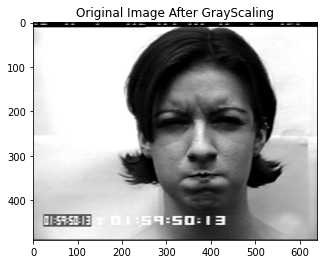

In [92]:
img = cv2.imread('p1.png')
p=anna_phog(img, 8, 360, 3, [0,490,0,490])
print((p))
show_images([img],['Original Image After GrayScaling'])


In [83]:
from commonfunctions import *
from skimage import io
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import os
import numpy as np
import argparse
import matplotlib.pyplot as plt
import cv2
import imageio


In [84]:
'''
https://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/

https://sci-hub.se/https://ieeexplore.ieee.org/document/5413938

https://www.robots.ox.ac.uk/~vgg/research/caltech/phog.html


Step 3: The HOG for each grid at each pyramid
resolution level was computed. Local shape is represented
by a histogram of edge orientations within an image subregion quantized into K bins

Step 4: The final PHOG descriptor for an image is a
concatenation of all the HOG vectors at each pyramid
resolution. The concatenation of all the HOG vectors
introduces the spatial information of the image. Each HOG
is normalized to sum to unity taking into account all the
pyramid levels. Consequently, level 0 is represented by a Kvector corresponding to the K bins of the histogram,

PHOG descriptor of the entire
image is a vector with dimensionality 4
K*sigma(4*pow(i))
For levels up
to L = 1 and K = 20 bins it is a 100-vector.

 
'''

'\nhttps://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/\n\nhttps://sci-hub.se/https://ieeexplore.ieee.org/document/5413938\n\nhttps://www.robots.ox.ac.uk/~vgg/research/caltech/phog.html\n\n\nStep 3: The HOG for each grid at each pyramid\nresolution level was computed. Local shape is represented\nby a histogram of edge orientations within an image subregion quantized into K bins\n\nStep 4: The final PHOG descriptor for an image is a\nconcatenation of all the HOG vectors at each pyramid\nresolution. The concatenation of all the HOG vectors\nintroduces the spatial information of the image. Each HOG\nis normalized to sum to unity taking into account all the\npyramid levels. Consequently, level 0 is represented by a Kvector corresponding to the K bins of the histogram,\n\nPHOG descriptor of the entire\nimage is a vector with dimensionality 4\nK*sigma(4*pow(i))\nFor levels up\nto L = 1 and K = 20 bins it is a 100-vector.\n\n \n'

In [95]:
def PHOG_Algorithm(image,numberOfBins,numberOfLevels):#Reading Image as gray scale
    dummy_value=1e-5
    degree=360/numberOfBins
    x,y=image.shape
    pyramidarr=np.array([])
    #Intializing binary histogram array and binary gradient values array 
    binaryHist = np.zeros((x,y))
    binaryGrad = np.zeros((x,y))
    
    if np.sum(image) >100:
        medianImg= np.median(image)
        
        canny_image= cv2.Canny(image, int(max(0, (1.0 - 0.33) * medianImg)), int(min(255, (1.0 + 0.33) * medianImg)))
        comps,labels= cv2.connectedComponents(canny_image, connectivity=8)
        double_image=np.array(image,dtype=np.float64)
        # Gradient is defined as (change in y)/(change in x)
        [gx, gy] = np.gradient(double_image)
        #print(gy)
        #print(gx)
        values= np.sqrt(np.square(gy)+np.square(gx))#
        #print(value)
        
        #i=np.array(gx == 0,dtype=np.int32)   
        gx[gx == 0]=dummy_value
        #gy2 = np.gradient(gy)[1]  
        
        #consider angle range is always 360 degrees
        aarray=np.divide((np.arctan2(gy, gx) + np.pi) * 180., np.pi)
        #print(labels)
        for k in range(comps):
            xcoordinate, ycoordinate = np.where(labels==k)
            #print(ycoordinate)
            #print(xcoordinate)
            for j in range(xcoordinate.shape[0]):
                ypoint = ycoordinate[j]
                xpoint = xcoordinate[j]

                z = np.ceil(aarray[xpoint,ypoint]/degree)
                if z==0: 
                    numberOfBins=1
                if values[xpoint,ypoint]>0:
                    binaryHist[xpoint,ypoint] = z
                    binaryGrad[xpoint,ypoint] = values[xpoint,ypoint]
        #Looping on each level in pyramid
        #histb=binaryHist[0:490,0:490]
        #gradb=binaryGrad[0:490,0:490]
        #print(len(binaryHist))
        #print(len(binaryGrad))
        histb=binaryHist
        gradb=binaryGrad
        for k in range(numberOfBins):
            ind = histb==k
            pyramidarr = np.append(pyramidarr, np.sum(gradb[ind]))

        #higher levels
        for level in range(1, numberOfLevels+1):
            y = int(np.trunc(histb.shape[0]/(2**level)))
            x = int(np.trunc(histb.shape[1]/(2**level)))
            for yy in range(0, histb.shape[0]-y+1, y):
                for xx in range(0, histb.shape[1]-x+1, x):
                    #print(pyramidarr)
                    binaryHist2 = histb[yy:yy+y,xx:xx+x]
                    binaryGrad2 = gradb[yy:yy+y,xx:xx+x]

                    for binofhist in range(numberOfBins):
                        ind = binaryHist2==binofhist
                        pyramidarr = np.append(pyramidarr, np.sum(binaryGrad2[ind], axis=0))
        
        if np.sum(pyramidarr)==0:
            return pyramidarr
        else:
            return pyramidarr/np.sum(pyramidarr)
        
    
    #return pyramidarr

[6.24151064e-02 2.32765844e-02 1.68784781e-02 8.99977279e-02
 3.92595729e-02 1.32617180e-02 1.32031493e-02 0.00000000e+00
 7.30654167e-03 7.89027713e-03 4.59752764e-03 3.50206105e-02
 4.27699393e-03 6.28273063e-04 8.75525293e-04 0.00000000e+00
 1.60701198e-02 2.72055700e-03 3.19615330e-04 2.52838141e-02
 1.07515071e-02 1.26496858e-03 2.33956838e-03 0.00000000e+00
 1.85928197e-02 6.25308978e-03 6.23645073e-03 1.50709281e-02
 1.19277773e-02 5.47205220e-03 4.19830530e-03 0.00000000e+00
 2.04456252e-02 6.41266053e-03 5.72488444e-03 1.46223752e-02
 1.23032946e-02 5.89642412e-03 5.78975032e-03 0.00000000e+00
 4.21453150e-03 5.49748267e-04 0.00000000e+00 1.65016533e-02
 2.78212230e-03 2.48711664e-04 3.80264473e-04 0.00000000e+00
 2.95371832e-03 4.27976052e-03 0.00000000e+00 1.70923233e-02
 1.49487164e-03 3.79561400e-04 4.95260820e-04 0.00000000e+00
 1.07446008e-02 2.21092166e-03 1.19852012e-04 1.33213191e-02
 4.94898042e-03 3.59505233e-04 3.28831923e-04 0.00000000e+00
 4.44889158e-03 5.679547

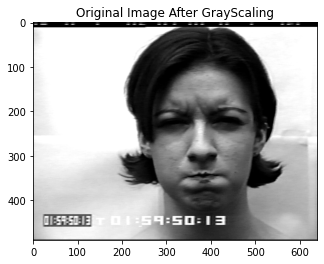

In [96]:
img = cv2.imread('p1.png',0)
p=PHOG_Algorithm(img,8,3)
print((p))
show_images([img],['Original Image After GrayScaling'])

